In [1]:
using NBInclude
@nbinclude("functions.ipynb")


All function imported


In [22]:
#setup
x_dim = 784
m = 200
k = 20
tolerance = 1e-7; max_iter = 2000; out_toggle = 0
trials = 20
opt = Flux.Optimise.ADAM(.1);
z = randn(k) # ground code vector

epoch_to_load = 17 # Load the model 
_, _, decoder_identity, decoder_last = load_model_identity("trained_GNN/MNIST_identity", epoch_to_load)
F = dct(diagm(ones(x_dim)),2);

_, _, decoder = load_model("trained_GNN/MNIST", 20)
A = Flux.params(decoder)[3]
β_list, α_list = get_β_α(F, A, decoder_last, 11);
recovery_error_matrix = zeros(trials, 1 + length(β_list) )
recon_error_matrix = zeros(trials, 1 + length(β_list) );
# subspace_incoherence(F,decoder_last)


Loading model...Done
Loading model...Done


20×12 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0

In [11]:
subspace_incoherence(F,decoder_last)


0.8183307031895922

In [23]:
Threads.@threads for i in 1:length(β_list)
    recovery_error_list = []
    recon_error_list = []
    β = β_list[i]
    G = Chain(
        Dense(20, 500, relu, bias = false; init =(out,in) -> Flux.params(decoder)[1]),
        Dense(500, 500, relu, bias = false; init =(out,in) -> Flux.params(decoder)[2]),
        Dense(500, 784, identity, bias = false; init =(out,in) -> β * A + (1-β)*decoder_last),
    )   #setup the generative network 

    for trials in 1:trials
        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
        y = F_sub * G(z) # measurement vector using subsampled DCT matrix
  
        z_est = randn(k) #initialization for algorithm
        z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

        push!(recovery_error_list, relative_error(z, z_est))    
        push!(recon_error_list, relative_error(G(z), G(z_est)))
    end

    recovery_error_matrix[:, i + 1] =  recovery_error_list
    recon_error_matrix[:, i + 1] = recon_error_list
end

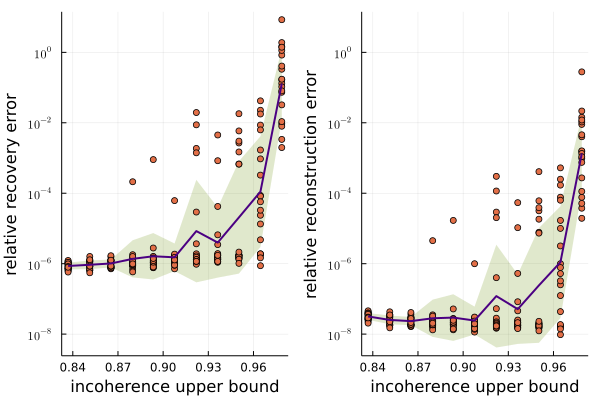

In [29]:
log_recovery_error_matrix = log10.(recovery_error_matrix[:, 2:end])
average_recov = mean(log_recovery_error_matrix, dims=1)'
std_recov = std(log_recovery_error_matrix, dims=1)'
plot(α_list, average_recov + std_recov, fillrange =  average_recov - std_recov, fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
scatter!(kron(α_list',ones(trials,1))[:], log_recovery_error_matrix[:], label =:false)
p1 = plot!(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false)
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])



log_recon_error_matrix = log10.(recon_error_matrix[:, 2:end])
average_recon = mean(log_recon_error_matrix, dims=1)'
std_recon = std(log_recon_error_matrix, dims=1)'
plot(α_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
scatter!(kron(α_list',ones(trials,1))[:], log_recon_error_matrix[:], label =:false)
p2 = plot!(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false )
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])


plot(p1,p2,layout = 2, ylims = (minimum([ylims(p1)[1],ylims(p2)[1]]), maximum([ylims(p1)[2],ylims(p2)[2]]) ))



In [26]:
std_recov = std(log_recovery_error_matrix, dims=1)'

11×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.09556447753539932
 0.12325806107329887
 0.11215058855713685
 0.5279793543846237
 0.6592537528696912
 0.3917245333942104
 1.4553187359558384
 0.9945775941949647
 1.5945384244380367
 1.5720202026019117
 1.0003929711835662

In [25]:

savefig("figures/Full_MNIST_incoherent_error.pdf")
save("saved_data/Full_incoherent_MNIST_error.jld", "recovery error", recovery_error_matrix, "reconstruction error", recon_error_matrix, "α_list", α_list)